In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit.extensions import XGate
from ibm_washington_config import coupling_map, basis_gates
from ionq_config import coupling_map, basis_gates

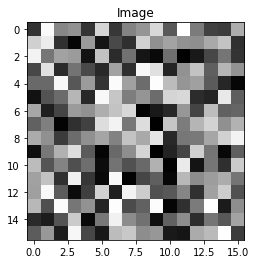

In [2]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

sort pixels

In [3]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [4]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

In [5]:
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_image = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(color)
qc_image.i(coordinate)
qc_image.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=color[0])
        else:
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=coordinate[0])
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
                
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 35  | 4 | 412| 199|
| 4  | 943  | 6 | 5513| 1855|
| 8  | 16063  | 8 | 97739| 31999|
| 16  | 260863  | 10 | | 521215|
| 32  | 4189183  | 12|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

In [6]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 260863, # of qubits is 10


In [26]:
wash_qc = transpile(circuits=qc_image, coupling_map=coupling_map, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 521215


In [8]:
# qc_image.draw()

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=100000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((key[0], amount))
                coord_list.append((key[1], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

the meauserd colors are 
 [ 58 256 136 147  55 212  59 128 153 219  89 256 126  67  59 161 208 233
  45   0 164  27  69  46 204 143 165 144 139 171 194  51 241 113 168 157
  20 197  47 111  21   8 115   0  23  71 116  54  71 220  52 103  74  40
 156  49 247 217  36 152 192  92 176 145 105 107 247  91 148  57 247 163
  99 256 181 143 169  91  35   8  18  85 109 175  43 248 200 121 146 115
 218 218  41  35 241  97 169  33  71 149 145 169 200 213   0  26  36 155
  69 189 103  99  99 129   0  45  65 219 241 121 214   0 199 126 184 207
 147 181 174 146  57 106 145 167 135 199 172 225  41 115 121 158 204 244
  16 118 176 223  89  11 104 137 207   0  36  73 199 110   0  89 181  79
 134  82 106   0 117  83 106 170   0 231  21 122  47 204 159 194  49 234
  57   8 256   7  67  95   0 180 132 165 162 119 155 256  96   7  61 212
  33 242 210  84  83 133  47 153 208  79 181  74 247 112 142  39 256  80
  99 256   7  46 127 256  26 141  43  28  82 197  12 126 242 138 112  15
  94 140  48 121  91 165 

As we can see above, probabilistic amplitude <ins>coordinate</ins> encoding fails

In [8]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

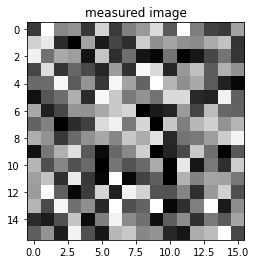

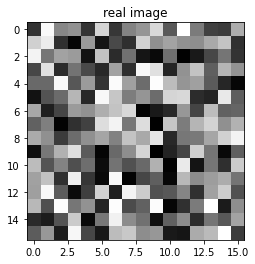

In [9]:
plot_to_compare(output_im, image)